In [117]:
#Import all of the packages we will need for this project
#Jupyter Lab 3.44, Python 3
import json
import pandas as pd
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sb
#This next line was ran in the commmand line
# pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks

In [118]:
#Parse for json gzip file downloaded from the links provided
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

In [119]:
# Function to turn json into df
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [120]:
#Importing data
df = getDF('Software.json.gz')
#View the dataset
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"03 11, 2014",A240ORQ2LF9LUI,0077613252,{'Format:': ' Loose Leaf'},Michelle W,The materials arrived early and were in excell...,Material Great,1394496000,NaN,NaN
1,4.0,True,"02 23, 2014",A1YCCU0YRLS0FE,0077613252,{'Format:': ' Loose Leaf'},Rosalind White Ames,I am really enjoying this book with the worksh...,Health,1393113600,NaN,NaN
2,1.0,True,"02 17, 2014",A1BJHRQDYVAY2J,0077613252,{'Format:': ' Loose Leaf'},Allan R. Baker,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ...",ARE YOU KIDING ME?,1392595200,7,NaN
3,3.0,True,"02 17, 2014",APRDVZ6QBIQXT,0077613252,{'Format:': ' Loose Leaf'},Lucy,This book was missing pages!!! Important pages...,missing pages!!,1392595200,3,NaN
4,5.0,False,"10 14, 2013",A2JZTTBSLS1QXV,0077775473,NaN,Albert V.,I have used LearnSmart and can officially say ...,Best study product out there!,1381708800,NaN,NaN


In [121]:
#New data frame with the new selected columns we need
df = df[['overall','reviewText']]
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459436 entries, 0 to 459435
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     459436 non-null  float64
 1   reviewText  459370 non-null  object 
dtypes: float64(1), object(1)
memory usage: 10.5+ MB


In [122]:
# Select the special characters
special_char = ["!",'"',"#","%","&","'","(",")",
 "*","+",",","-",".","/",":",";","<",
 "=",">","?","@","[","\\","]","^","_",
 "`","{","|","}","~","–"]

In [123]:
# Rename Columns
df = df.rename(columns={'overall': 'Score', 'reviewText': 'Review'})
df.head()

,Score,Review
0,4.0,The materials arrived early and were in excell...
1,4.0,I am really enjoying this book with the worksh...
2,1.0,"IF YOU ARE TAKING THIS CLASS DON""T WASTE YOUR ..."
3,3.0,This book was missing pages!!! Important pages...
4,5.0,I have used LearnSmart and can officially say ...


In [124]:
# Check for nulls
df.isna().any()

Score     False
Review     True
dtype: bool

In [125]:
# Remove nulls from where it says “True” above this cell
df = df.dropna(subset=['Review'])

In [126]:
# Verify we do not have any nulls
df.isna().any()

Score     False
Review    False
dtype: bool

In [127]:
# replace the special characters with spaces
for char in special_char:
 df['Review'] = df['Review'].str.replace(char, ' ',regex=True)

In [128]:
# Replace capitals with lowercase letters
df['Review'] = df['Review'].str.lower()
df.head()

,Score,Review
0,4.0,the materials arrived early and were in excell...
1,4.0,i am really enjoying this book with the worksh...
2,1.0,if you are taking this class don t waste your ...
3,3.0,this book was missing pages important pages...
4,5.0,i have used learnsmart and can officially say ...


In [129]:
# Create sentiments column from the dataset (Changing numeric review answers to positive and #negative sentiments. review 0-2 negative, 3-5 positive
# 0 = negative, 1 = positive
df['Sentiments'] = df.Score.apply(lambda x: 0 if x in [1, 2] else 1)
df.head()

,Score,Review,Sentiments
0,4.0,the materials arrived early and were in excell...,1
1,4.0,i am really enjoying this book with the worksh...,1
2,1.0,if you are taking this class don t waste your ...,0
3,3.0,this book was missing pages important pages...,1
4,5.0,i have used learnsmart and can officially say ...,1


In [130]:
# export the prepared data
df.to_csv('D213_Task2_cleaned.csv', index = False)

In [131]:
# Split data into 80/20 training and testing, standard for testing datasets and looking for high accuracy
split = round(len(df)*0.8)
train_reviews = df['Review'][:split]
train_label = df['Sentiments'][:split]
test_reviews = df['Review'][split:]
test_label = df['Sentiments'][split:]

In [132]:
#Changing each review into a string after tokenization
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for row in train_reviews:
    training_sentences.append(str(row))
for row in train_label:
    training_labels.append(row)
for row in test_reviews:
    testing_sentences.append(str(row))
for row in test_label:
    testing_labels.append(row)

In [133]:
#View the max vocab
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
print(len(tokenizer.word_index) + 1)

130085


In [134]:
# Getting the word index (vocabulary size)
word_index = tokenizer.word_index
word_index

{'the': 1,
 'i': 2,
 'to': 3,
 'and': 4,
 'it': 5,
 'a': 6,
 'of': 7,
 'is': 8,
 'for': 9,
 'this': 10,
 'you': 11,
 'that': 12,
 'my': 13,
 'in': 14,
 'with': 15,
 'have': 16,
 'on': 17,
 'not': 18,
 'was': 19,
 'but': 20,
 't': 21,
 'as': 22,
 'software': 23,
 's': 24,
 'so': 25,
 'be': 26,
 'are': 27,
 'can': 28,
 'product': 29,
 'if': 30,
 'use': 31,
 'all': 32,
 'from': 33,
 'program': 34,
 'or': 35,
 'me': 36,
 'they': 37,
 'had': 38,
 'your': 39,
 'do': 40,
 'an': 41,
 'will': 42,
 'version': 43,
 'very': 44,
 'no': 45,
 'one': 46,
 'at': 47,
 'get': 48,
 'just': 49,
 'would': 50,
 'up': 51,
 'has': 52,
 'time': 53,
 'like': 54,
 'windows': 55,
 'when': 56,
 'there': 57,
 'more': 58,
 'computer': 59,
 'what': 60,
 'great': 61,
 'out': 62,
 'been': 63,
 'work': 64,
 'good': 65,
 'used': 66,
 'new': 67,
 'only': 68,
 'years': 69,
 'using': 70,
 'easy': 71,
 'some': 72,
 'which': 73,
 'than': 74,
 'other': 75,
 'about': 76,
 'after': 77,
 'don': 78,
 'am': 79,
 'now': 80,
 'by': 81

In [135]:
#Setting vocab size to 130086, aka taking 130086 words to train
vocab_size = 130086
# View the embedding length
max_sequence_embedding = int(round(np.sqrt(np.sqrt(vocab_size)), 0))
max_sequence_embedding

19

In [136]:
# Embedding to 19 dimensions, given from the above code
embedding_dim = 19
# Max length of 150 words per review as a cut off
max_length = 150
#If review is bigger than 150 words, it will be truncated "post" or after the 150th word
trunc_type = 'post'
oov_tok = '<OOV>'
# Padding type "post" meaning each word will receive padding after, not before
padding_type = 'post'

In [137]:
#Starting the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Fitting the tokenizer
tokenizer.fit_on_texts(training_sentences)

In [138]:
#Setting the sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
#Setting the padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [139]:
# Let’s check out the padded array
padded
print(df)

        Score                                             Review  Sentiments
0         4.0  the materials arrived early and were in excell...           1
1         4.0  i am really enjoying this book with the worksh...           1
2         1.0  if you are taking this class don t waste your ...           0
3         3.0  this book was missing pages    important pages...           1
4         5.0  i have used learnsmart and can officially say ...           1
...       ...                                                ...         ...
459431    2.0  no instructions     no help unless you want to...           0
459432    1.0                                        it s a joke           0
459433    5.0  i have multiple licenses of the antivirus  i h...           1
459434    5.0                                         good value           1
459435    5.0                     very nice designs easy to use            1

[459370 rows x 3 columns]


In [140]:
#Time to create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

In [141]:
#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 19)           2471634   
                                                                 
 global_average_pooling1d_6   (None, 19)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_17 (Dense)            (None, 10)                200       
                                                                 
 dense_18 (Dense)            (None, 6)                 66        
                                                                 
 dense_19 (Dense)            (None, 1)                 7         
                                                                 
Total params: 2,471,907
Trainable params: 2,471,907
Non-trainable params: 0
____________________________________________

In [142]:
#Train the model
training_final = np.array(training_labels)
testing_final = np.array(testing_labels)
# Run the model for 25 epochs
model1 = model.fit(padded, training_final, epochs=25, validation_data=(testing_padded,
testing_final))
# We need to stop the model Early to prevent overfitting of the model
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 2, 
                                        restore_best_weights = True)

Epoch 1/25
11485/11485 [==============================] - 333s 29ms/step - loss: 0.3631 - accuracy: 0.8483 - val_loss: 0.3563 - val_accuracy: 0.8652
Epoch 2/25
11485/11485 [==============================] - 332s 29ms/step - loss: 0.2890 - accuracy: 0.8870 - val_loss: 0.3501 - val_accuracy: 0.8645
Epoch 3/25
11485/11485 [==============================] - 333s 29ms/step - loss: 0.3462 - accuracy: 0.8606 - val_loss: 0.3660 - val_accuracy: 0.8699
Epoch 4/25
11485/11485 [==============================] - 335s 29ms/step - loss: 0.3162 - accuracy: 0.8705 - val_loss: 0.3476 - val_accuracy: 0.8701
Epoch 5/25
11485/11485 [==============================] - 333s 29ms/step - loss: 0.2852 - accuracy: 0.8905 - val_loss: 0.3577 - val_accuracy: 0.8763
Epoch 6/25
11485/11485 [==============================] - 333s 29ms/step - loss: 0.2901 - accuracy: 0.8869 - val_loss: 0.3408 - val_accuracy: 0.8718
Epoch 7/25
11485/11485 [==============================] - 332s 29ms/step - loss: 0.2922 - accuracy: 0.8905

In [143]:
# Time to run the model again and see our accuracy
model2 = model.fit(padded, training_final, epochs=25, validation_data=(testing_padded,
                                                                       testing_final),
                                                                       callbacks = [earlystopping])

Epoch 1/25
11485/11485 [==============================] - 327s 28ms/step - loss: 0.2312 - accuracy: 0.9153 - val_loss: 0.3715 - val_accuracy: 0.8639
Epoch 2/25
11485/11485 [==============================] - 327s 28ms/step - loss: 0.2261 - accuracy: 0.9165 - val_loss: 0.3883 - val_accuracy: 0.8708
Epoch 3/25
11485/11485 [==============================] - 327s 28ms/step - loss: 0.2349 - accuracy: 0.9138 - val_loss: 0.3749 - val_accuracy: 0.8652


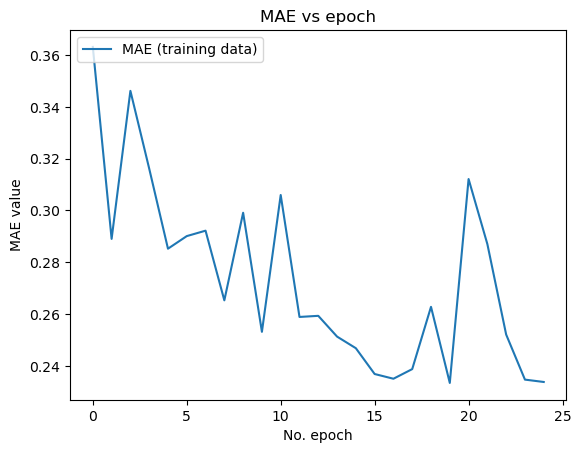

In [144]:
# epoch vs Mean Absolute Error (MAE)
mpl.plot(model1.history['loss'], label='MAE (training data)')
mpl.title('MAE vs epoch')
mpl.ylabel('MAE value')
mpl.xlabel('No. epoch')
mpl.legend(loc="upper left")
mpl.show()

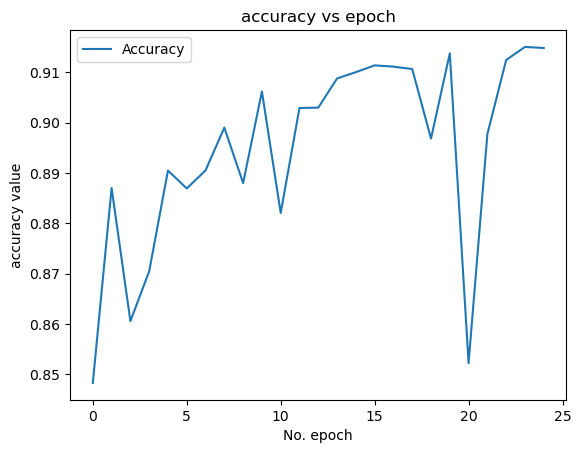

In [145]:
#Check our accuracy per Epoch
mpl.plot(model1.history['accuracy'], label='Accuracy')
mpl.title('accuracy vs epoch')
mpl.ylabel('accuracy value')
mpl.xlabel('No. epoch')
mpl.legend(loc="upper left")
mpl.show()

<Figure size 640x480 with 0 Axes>

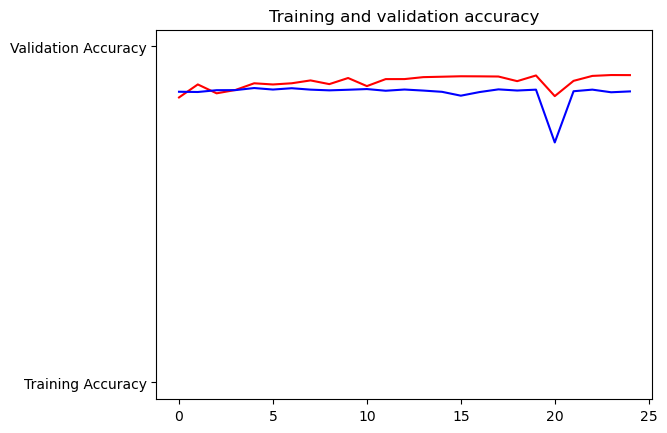

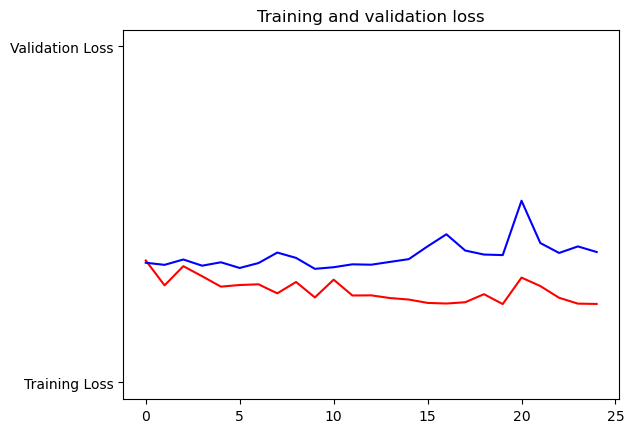

<Figure size 640x480 with 0 Axes>

In [146]:
#Training versus Accuracy
acc = model1.history['accuracy']
val_acc = model1.history['val_accuracy']
loss = model1.history['loss']
val_loss = model1.history['val_loss']
epochs=range(len(acc))
mpl.plot(epochs, acc, 'r', 'Training Accuracy')
mpl.plot(epochs, val_acc, 'b', 'Validation Accuracy')
mpl.title('Training and validation accuracy')
mpl.figure()
mpl.plot(epochs, loss, 'r', 'Training Loss')
mpl.plot(epochs, val_loss, 'b', 'Validation Loss')
mpl.title('Training and validation loss')
mpl.figure()

In [152]:
#Exports
train_reviews.to_csv('D213_Task2_train_reviews.csv', index = False)
train_label.to_csv('D213_Task2_train_label.csv', index = False)
test_reviews.to_csv('D213_Task2_test_reviews.csv', index = False)
test_label.to_csv('D213_Task2_test_label.csv', index = False)

In [153]:
df.to_csv('D213_Task2_df_Ready_to_Run.csv', index = False)

In [154]:
#Saving our model
model.save('D213_Task2_Model.h5')